In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose

## We are going to train our model with images, so using GPU becomes a must.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


## A. Let's examine the dataset

In [ ]:
#we Converting data to tensor format
transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
train_path = './cifar10/train/'
test_path = './cifar10/test/'

In [ ]:
#Downloading And we run the transform on it
trainset = datasets.CIFAR10(train_path, download=True, train=True, transform=transform)
valset = datasets.CIFAR10(test_path, download=True, train=False, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Extracting ./cifar10/train/cifar-10-python.tar.gz to ./cifar10/train/


100%|██████████| 170M/170M [00:05<00:00, 30.5MB/s]


Extracting ./cifar10/test/cifar-10-python.tar.gz to ./cifar10/test/


In [ ]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
# Checking data dimensions
print(trainset.data.shape)
targets = np.array(trainset.targets)
print(targets.shape)
print(valset.data.shape)
targets = np.array(valset.targets)
print(targets.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [ ]:
# DataLoaders going to help us. What are they doing?
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images ,labels = next(dataiter)


print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


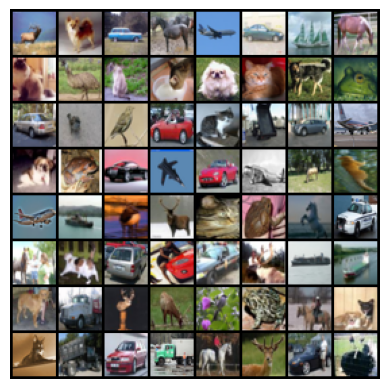

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# show images
imshow(torchvision.utils.make_grid(images))




##B. CNN


In [ ]:
# We used data augmentation here, what is data augmentation?
train_transform = Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])


trainset = datasets.CIFAR10(train_path, download=True, train=True, transform=train_transform)
valset = datasets.CIFAR10(test_path, download=True, train=False, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Our CNN implement, 3 conv layer, pooling before fully connected Then fully connected layer for outputing our 10 classes
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


model = Net()

In [ ]:
_ = model.to(device)

In [ ]:
# Model Hyperparameters, you can change every one of them to trying it with new parameters
criterion = nn.CrossEntropyLoss() # also can use "Mean Squared Error Loss"
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)#also can use "Adam Optimizer"
val_per_epoch = 5
n_epochs = 30
batch_size = 4

#tuning Hyperparameters is important and difficult.

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [ ]:
#Training loop

history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(trainloader)
        running_acc = running_acc / len(trainloader)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_per_epoch == val_per_epoch-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(valloader)):
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(valloader)
                running_acc = running_acc / len(valloader)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

100%|██████████| 12500/12500 [01:11<00:00, 176.00it/s]


Epoch 1/30 : training loss: 1.6993854213047028, training acc: 0.36508


100%|██████████| 12500/12500 [01:08<00:00, 183.65it/s]


Epoch 2/30 : training loss: 1.38437528616786, training acc: 0.49676


100%|██████████| 12500/12500 [01:09<00:00, 180.67it/s]


Epoch 3/30 : training loss: 1.2061526553940773, training acc: 0.57012


100%|██████████| 12500/12500 [01:08<00:00, 183.78it/s]


Epoch 4/30 : training loss: 1.0689077391451598, training acc: 0.62248


100%|██████████| 12500/12500 [01:07<00:00, 184.01it/s]


Epoch 5/30 : training loss: 0.9653590541303531, training acc: 0.66046


100%|██████████| 2500/2500 [00:08<00:00, 301.76it/s]


Epoch 5/30 : validation loss: 0.8315612663730979, validation acc: 0.708


100%|██████████| 12500/12500 [01:07<00:00, 185.16it/s]


Epoch 6/30 : training loss: 0.8896489853904397, training acc: 0.69036


100%|██████████| 12500/12500 [01:07<00:00, 184.40it/s]


Epoch 7/30 : training loss: 0.8308638669302687, training acc: 0.70794


100%|██████████| 12500/12500 [01:08<00:00, 181.59it/s]


Epoch 8/30 : training loss: 0.7829960590279847, training acc: 0.72714


100%|██████████| 12500/12500 [01:10<00:00, 177.98it/s]


Epoch 9/30 : training loss: 0.7485750635964423, training acc: 0.7381


100%|██████████| 12500/12500 [01:09<00:00, 180.83it/s]


Epoch 10/30 : training loss: 0.7089376221980993, training acc: 0.75388


100%|██████████| 2500/2500 [00:08<00:00, 285.57it/s]


Epoch 10/30 : validation loss: 0.7621878158475854, validation acc: 0.7403


100%|██████████| 12500/12500 [01:09<00:00, 181.00it/s]


Epoch 11/30 : training loss: 0.6796187270232057, training acc: 0.76374


100%|██████████| 12500/12500 [01:09<00:00, 180.65it/s]


Epoch 12/30 : training loss: 0.6530344177805819, training acc: 0.7735


100%|██████████| 12500/12500 [01:08<00:00, 182.68it/s]


Epoch 13/30 : training loss: 0.6328380147011485, training acc: 0.78184


100%|██████████| 12500/12500 [01:09<00:00, 179.86it/s]


Epoch 14/30 : training loss: 0.6113929564505435, training acc: 0.78802


100%|██████████| 12500/12500 [01:09<00:00, 180.87it/s]


Epoch 15/30 : training loss: 0.5940671112418314, training acc: 0.79486


100%|██████████| 2500/2500 [00:08<00:00, 291.91it/s]


Epoch 15/30 : validation loss: 0.6190560039982899, validation acc: 0.7883


 10%|█         | 1272/12500 [00:07<01:03, 175.95it/s]

In [ ]:
# Review results
from sklearn.metrics import confusion_matrix ,f1_score ,precision_score ,recall_score, accuracy_score

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, valloader)
print('Accuracy: %f' % accuracy_score(actuals, predictions))
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='weighted'))
print('Precision: %f' % precision_score(actuals, predictions, average='weighted'))
print('Recall: %f' % recall_score(actuals, predictions, average='weighted'))

Accuracy: 0.821600
Confusion matrix:
[[824  15  33  12  13   1   3   6  57  36]
 [  7 902   3   2   2   1   1   0  10  72]
 [ 37   1 781  25  64  23  27  16  16  10]
 [ 19   4  65 611  85 102  38  41   9  26]
 [  7   2  45  22 866   9  18  21   6   4]
 [  8   1  49 109  55 700  14  51   4   9]
 [  9   2  44  35  41   6 833   9  13   8]
 [ 10   2  16  17  41  16   3 879   5  11]
 [ 37  16   7   6   5   0   1   2 890  36]
 [ 14  27   3   3   2   1   2   6  12 930]]
F1 score: 0.820015
Precision: 0.822452
Recall: 0.821600


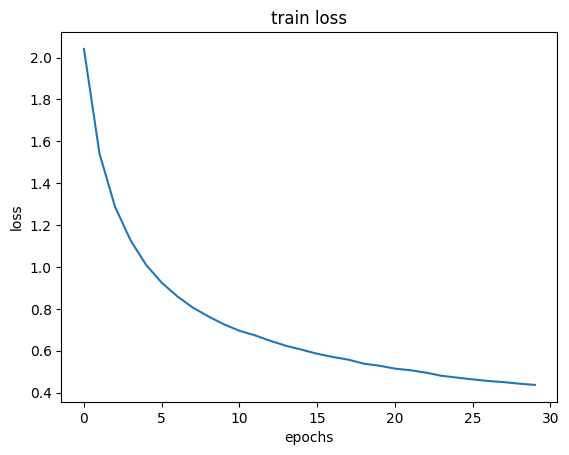

In [ ]:
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

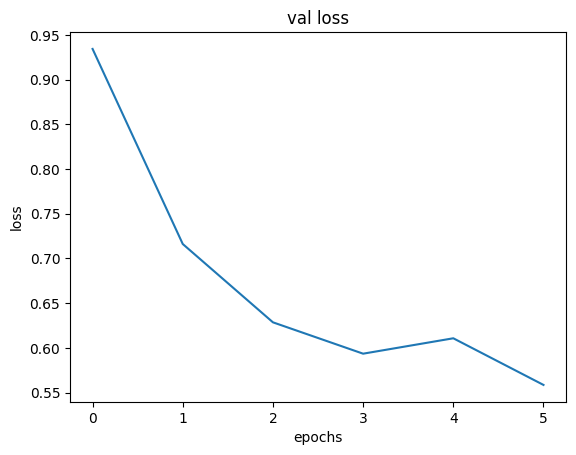

In [ ]:
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

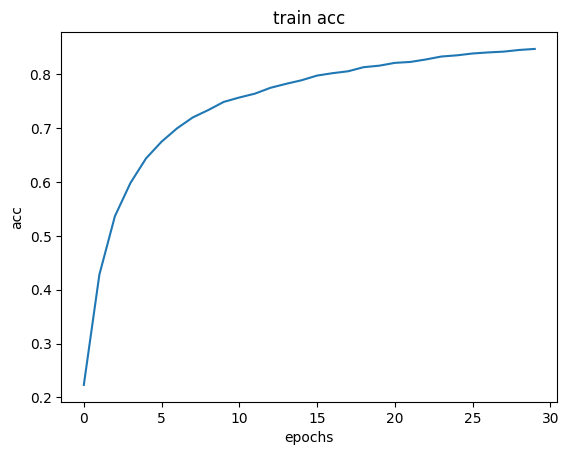

In [ ]:
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

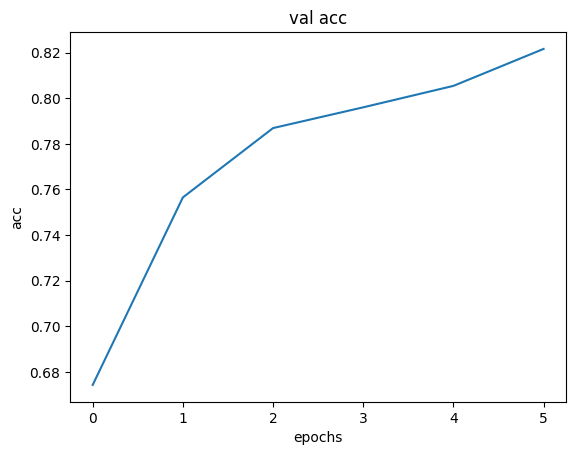

In [ ]:
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

##C. CNN WITH DROPOUT


In [ ]:
# Adding DropOut here. What is DropOut?, what is advantages and disadvantages?, how result going to be different?
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.do1 = nn.Dropout(0.2)  # 20% Probability
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.do2 = nn.Dropout(0.2)  # 20% Probability
        self.fc2 = nn.Linear(128, 256)
        self.do3 = nn.Dropout(0.1)  # 10% Probability
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.do1(x)
        x = F.relu(self.fc1(x))
        x = self.do2(x)
        x = F.relu(self.fc2(x))
        x = self.do3(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


model = Net()

In [ ]:
_ = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
val_per_epoch = 5
n_epochs = 30
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
def accuracy(y_pred, y):
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [ ]:
history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(trainloader)
        running_acc = running_acc / len(trainloader)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_per_epoch == val_per_epoch-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(valloader)):
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(valloader)
                running_acc = running_acc / len(valloader)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

100%|██████████| 12500/12500 [01:16<00:00, 164.47it/s]


Epoch 1/30 : training loss: 1.9970659666204453, training acc: 0.23794


100%|██████████| 12500/12500 [01:14<00:00, 168.35it/s]


Epoch 2/30 : training loss: 1.5644753866314889, training acc: 0.42494


100%|██████████| 12500/12500 [01:15<00:00, 164.51it/s]


Epoch 3/30 : training loss: 1.3483644575583935, training acc: 0.51308


100%|██████████| 12500/12500 [01:14<00:00, 166.91it/s]


Epoch 4/30 : training loss: 1.2054294063639641, training acc: 0.56866


100%|██████████| 12500/12500 [01:15<00:00, 164.77it/s]


Epoch 5/30 : training loss: 1.0973083223313094, training acc: 0.61326


100%|██████████| 2500/2500 [00:09<00:00, 264.59it/s]


Epoch 5/30 : validation loss: 0.912270200554654, validation acc: 0.689


100%|██████████| 12500/12500 [01:14<00:00, 166.92it/s]


Epoch 6/30 : training loss: 1.0137941915964335, training acc: 0.64578


100%|██████████| 12500/12500 [01:16<00:00, 164.24it/s]


Epoch 7/30 : training loss: 0.9448282415347546, training acc: 0.67072


100%|██████████| 12500/12500 [01:15<00:00, 164.88it/s]


Epoch 8/30 : training loss: 0.9004457691719756, training acc: 0.68776


100%|██████████| 12500/12500 [01:14<00:00, 167.79it/s]


Epoch 9/30 : training loss: 0.8592760117303208, training acc: 0.70104


100%|██████████| 12500/12500 [01:14<00:00, 166.91it/s]


Epoch 10/30 : training loss: 0.8259481219575554, training acc: 0.71644


100%|██████████| 2500/2500 [00:09<00:00, 277.42it/s]


Epoch 10/30 : validation loss: 0.6977501902006567, validation acc: 0.76


100%|██████████| 12500/12500 [01:13<00:00, 170.43it/s]


Epoch 11/30 : training loss: 0.7927741086973622, training acc: 0.72666


100%|██████████| 12500/12500 [01:14<00:00, 168.34it/s]


Epoch 12/30 : training loss: 0.7673440267624426, training acc: 0.73508


100%|██████████| 12500/12500 [01:12<00:00, 171.63it/s]


Epoch 13/30 : training loss: 0.7465483445060812, training acc: 0.74162


100%|██████████| 12500/12500 [01:14<00:00, 168.67it/s]


Epoch 14/30 : training loss: 0.7214266535418666, training acc: 0.75052


100%|██████████| 12500/12500 [01:12<00:00, 171.93it/s]


Epoch 15/30 : training loss: 0.7000342168990895, training acc: 0.75646


100%|██████████| 2500/2500 [00:09<00:00, 269.96it/s]


Epoch 15/30 : validation loss: 0.6326108823824674, validation acc: 0.786


100%|██████████| 12500/12500 [01:12<00:00, 171.60it/s]


Epoch 16/30 : training loss: 0.6869723425743776, training acc: 0.76466


100%|██████████| 12500/12500 [01:13<00:00, 168.94it/s]


Epoch 17/30 : training loss: 0.6793352741305669, training acc: 0.76774


100%|██████████| 12500/12500 [01:12<00:00, 171.68it/s]


Epoch 18/30 : training loss: 0.6622077982907276, training acc: 0.77184


100%|██████████| 12500/12500 [01:14<00:00, 168.62it/s]


Epoch 19/30 : training loss: 0.6493674316854495, training acc: 0.77548


100%|██████████| 12500/12500 [01:13<00:00, 170.88it/s]


Epoch 20/30 : training loss: 0.6425865546891186, training acc: 0.77996


100%|██████████| 2500/2500 [00:08<00:00, 280.97it/s]


Epoch 20/30 : validation loss: 0.5800665023620474, validation acc: 0.8014


100%|██████████| 12500/12500 [01:12<00:00, 172.23it/s]


Epoch 21/30 : training loss: 0.6310813727875916, training acc: 0.78324


100%|██████████| 12500/12500 [01:13<00:00, 169.33it/s]


Epoch 22/30 : training loss: 0.6143331108604779, training acc: 0.78992


100%|██████████| 12500/12500 [01:12<00:00, 172.63it/s]


Epoch 23/30 : training loss: 0.6077411961302115, training acc: 0.79128


100%|██████████| 12500/12500 [01:13<00:00, 169.96it/s]


Epoch 24/30 : training loss: 0.5980866423945047, training acc: 0.7955


100%|██████████| 12500/12500 [01:12<00:00, 172.80it/s]


Epoch 25/30 : training loss: 0.5907064702541107, training acc: 0.79728


100%|██████████| 2500/2500 [00:09<00:00, 271.84it/s]


Epoch 25/30 : validation loss: 0.5536422258980922, validation acc: 0.8111


100%|██████████| 12500/12500 [01:12<00:00, 173.11it/s]


Epoch 26/30 : training loss: 0.5766129667067007, training acc: 0.80272


100%|██████████| 12500/12500 [01:12<00:00, 171.73it/s]


Epoch 27/30 : training loss: 0.5715429960513806, training acc: 0.80526


100%|██████████| 12500/12500 [01:11<00:00, 173.65it/s]


Epoch 28/30 : training loss: 0.5618441223370318, training acc: 0.80602


100%|██████████| 12500/12500 [01:13<00:00, 171.11it/s]


Epoch 29/30 : training loss: 0.5585207219273194, training acc: 0.80844


100%|██████████| 12500/12500 [01:11<00:00, 173.91it/s]


Epoch 30/30 : training loss: 0.548224891976341, training acc: 0.81096


100%|██████████| 2500/2500 [00:08<00:00, 277.82it/s]

Epoch 30/30 : validation loss: 0.5598857015680807, validation acc: 0.8153


In [ ]:
#Review the results
from sklearn.metrics import confusion_matrix ,f1_score ,precision_score ,recall_score, accuracy_score

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, valloader)
print('Accuracy: %f' % accuracy_score(actuals, predictions))
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='weighted'))
print('Precision: %f' % precision_score(actuals, predictions, average='weighted'))
print('Recall: %f' % recall_score(actuals, predictions, average='weighted'))

Accuracy: 0.815300
Confusion matrix:
[[832   6  24  19   6   4   6  10  39  54]
 [  7 837   3   1   0   4   7   1  13 127]
 [ 53   2 729  28  44  63  50  13   9   9]
 [ 13   1  57 595  47 195  49  17   8  18]
 [  8   1  39  33 830  19  40  23   5   2]
 [  5   0  24  76  33 822  10  24   1   5]
 [  5   0  40  29  14  26 879   0   3   4]
 [ 13   2  24  23  60  46   4 809   4  15]
 [ 48   6   8   9   4   3   4   2 872  44]
 [ 10   9   3   6   1   3   6   5   9 948]]
F1 score: 0.814607
Precision: 0.819818
Recall: 0.815300


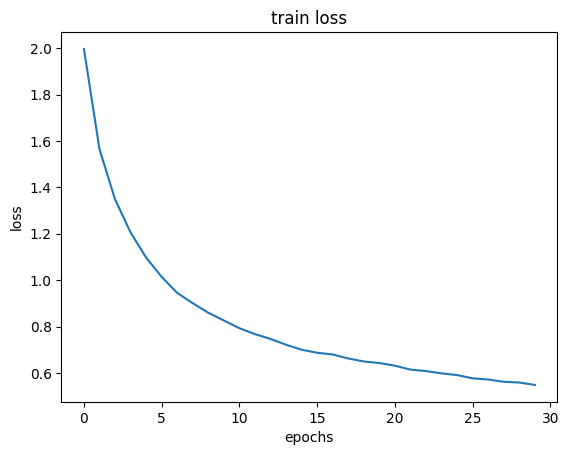

In [ ]:
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

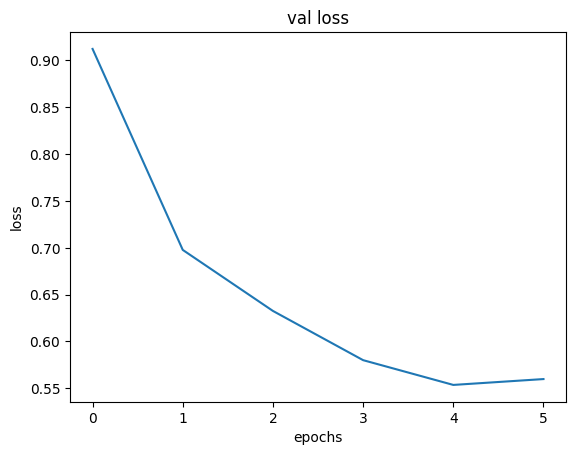

In [ ]:
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

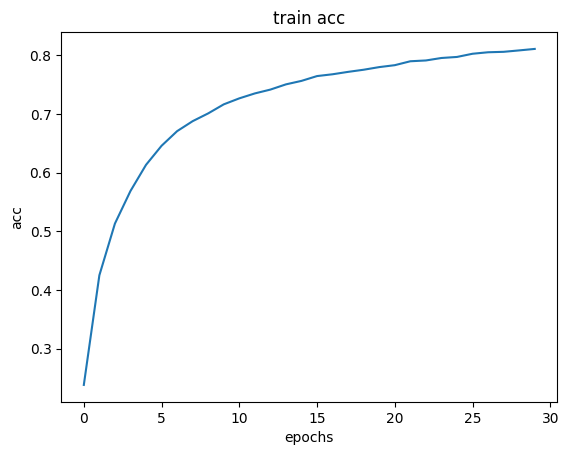

In [ ]:
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

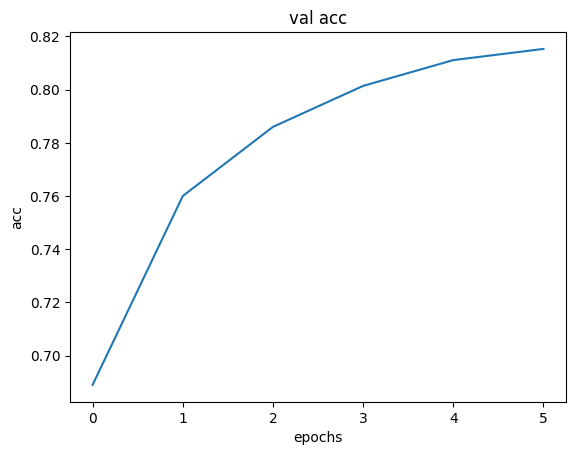

In [ ]:
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

# MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score


In [2]:

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.0243
Epoch [2/10], Loss: 0.0240
Epoch [3/10], Loss: 0.0016
Epoch [4/10], Loss: 0.0019
Epoch [5/10], Loss: 0.0555
Epoch [6/10], Loss: 0.0006
Epoch [7/10], Loss: 0.0133
Epoch [8/10], Loss: 0.0012
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0018


Accuracy of the model on the test images: 99.02 %
Error Rate: 0.980000000000004 %
Precision: 0.9902637516949507
Recall: 0.9902
Confusion Matrix:
 [[ 970    0    3    0    0    3    3    0    0    1]
 [   0 1129    1    2    0    0    0    2    1    0]
 [   2    0 1027    0    1    0    0    2    0    0]
 [   0    0    1  995    0    9    0    1    4    0]
 [   0    0    1    0  968    0    3    2    0    8]
 [   0    0    0    1    0  889    2    0    0    0]
 [   2    2    2    0    1    2  948    0    1    0]
 [   0    0   11    0    0    0    0 1014    0    3]
 [   0    0    1    1    3    3    0    0  965    1]
 [   0    0    1    0    2    6    0    3    0  997]]


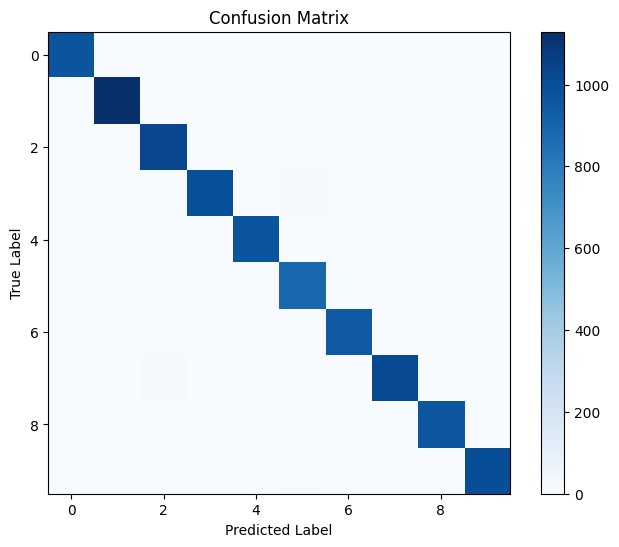

In [7]:

# Evaluate the model on GPU
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
error_rate = 100 - accuracy
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print('Accuracy of the model on the test images: {} %'.format(accuracy))
print('Error Rate: {} %'.format(error_rate))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Confusion Matrix:\n', conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Do not go furhter, that does not working very well... Use the previous code instead

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNISTClassifier()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap train_loader with tqdm to show a progress bar
    with tqdm(train_loader, unit="batch") as train_progress:
        train_progress.set_description(f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Update tqdm description with loss for the current batch
            train_progress.set_postfix(loss=loss.item())

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss}")


Epoch 1/20: 100%|██████████| 469/469 [00:16<00:00, 28.60batch/s, loss=2.3]


Epoch 1/20, Average Loss: 2.308542772650973


Epoch 2/20: 100%|██████████| 469/469 [00:16<00:00, 28.39batch/s, loss=2.31]


Epoch 2/20, Average Loss: 2.308547467819409


Epoch 3/20: 100%|██████████| 469/469 [00:16<00:00, 28.14batch/s, loss=2.31]


Epoch 3/20, Average Loss: 2.308544618488629


Epoch 4/20: 100%|██████████| 469/469 [00:16<00:00, 28.96batch/s, loss=2.3]


Epoch 4/20, Average Loss: 2.308538996588701


Epoch 5/20: 100%|██████████| 469/469 [00:16<00:00, 28.99batch/s, loss=2.32]


Epoch 5/20, Average Loss: 2.30855031918361


Epoch 6/20: 100%|██████████| 469/469 [00:17<00:00, 26.80batch/s, loss=2.3]


Epoch 6/20, Average Loss: 2.3085401007361503


Epoch 7/20: 100%|██████████| 469/469 [00:16<00:00, 29.20batch/s, loss=2.3]


Epoch 7/20, Average Loss: 2.308541287745494


Epoch 8/20: 100%|██████████| 469/469 [00:16<00:00, 28.49batch/s, loss=2.3]


Epoch 8/20, Average Loss: 2.3085410676277016


Epoch 9/20: 100%|██████████| 469/469 [00:16<00:00, 28.24batch/s, loss=2.3]


Epoch 9/20, Average Loss: 2.30854127554497


Epoch 10/20: 100%|██████████| 469/469 [00:16<00:00, 28.54batch/s, loss=2.31]


Epoch 10/20, Average Loss: 2.308544791837745


Epoch 11/20: 100%|██████████| 469/469 [00:16<00:00, 28.91batch/s, loss=2.32]


Epoch 11/20, Average Loss: 2.3085493634758727


Epoch 12/20: 100%|██████████| 469/469 [00:16<00:00, 29.08batch/s, loss=2.32]


Epoch 12/20, Average Loss: 2.3085504594896396


Epoch 13/20: 100%|██████████| 469/469 [00:17<00:00, 27.53batch/s, loss=2.3]


Epoch 13/20, Average Loss: 2.30854232580677


Epoch 14/20: 100%|██████████| 469/469 [00:16<00:00, 28.74batch/s, loss=2.32]


Epoch 14/20, Average Loss: 2.308551024272244


Epoch 15/20: 100%|██████████| 469/469 [00:16<00:00, 28.87batch/s, loss=2.3]


Epoch 15/20, Average Loss: 2.3085422292192863


Epoch 16/20: 100%|██████████| 469/469 [00:16<00:00, 28.37batch/s, loss=2.32]


Epoch 16/20, Average Loss: 2.3085507650111023


Epoch 17/20: 100%|██████████| 469/469 [00:16<00:00, 28.62batch/s, loss=2.31]


Epoch 17/20, Average Loss: 2.3085454013556053


Epoch 18/20: 100%|██████████| 469/469 [00:16<00:00, 29.14batch/s, loss=2.31]


Epoch 18/20, Average Loss: 2.308547652352339


Epoch 19/20: 100%|██████████| 469/469 [00:16<00:00, 28.56batch/s, loss=2.29]


Epoch 19/20, Average Loss: 2.308535895113752


Epoch 20/20: 100%|██████████| 469/469 [00:17<00:00, 27.52batch/s, loss=2.31]

Epoch 20/20, Average Loss: 2.308544043030566


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.05
Precision: 0.70
Recall: 0.05
F1 Score: 0.02
Confusion Matrix:
[[ 224  704    0    0    0    0    0    0    0   52]
 [  33    1    0    0    0    0    0    0    0 1101]
 [ 354  275    0    0    0    0    0    0    0  403]
 [ 651  104    0    0    0    0    0    0    0  255]
 [ 255  230    0    0    0    0    0    0    0  497]
 [ 373  244    0    0    0    0    0    0    0  275]
 [ 211  567    0    0    0    0    0    0    0  180]
 [ 530   54    0    0    0    0    0    0    0  444]
 [ 500   73    0    0    0    0    0    0    0  401]
 [ 641  122    0    0    0    0    0    0    0  246]]
